# Importación de librerías y creación de variables

In [15]:
import numpy as np
import matplotlib.pyplot as plt

n = 2 # Number of stacks of Miller indexes in each direction
a = 1.0 # Lattice constant

lambda_X = 1.54 # X-ray wavelength in Angstroms

f_O = 8 # Atomic form factor for Oxygen
f_Cu = 29 # Atomic form factor for Copper

# Diccionario para almacenar los factores de forma atómicos:
f = {
    "O": f_O,
    "Cu": f_Cu
}

# Esto al principio lo tenia así, pero le pregunte chatgpt y me dijo que para tenerlos en el mismo array era mejor separarlos usando un diccionario. Le pregunte por que me salío un error
# y lo tenía originalmente así:
# base_O_Cu = np.array([[0, 0, 0], [1/2, 1/2, 1/2]],[[1/4, 1/4, 1/4], [1/4, 3/4, 3/4], [3/4, 1/4, 3/4], [3/4, 3/4, 1/4]], dtype=float) # BCC Oxygen, FCC Copper
# Pero ahora aprendi a usar diccionarios
base_O = a * np.array([
    [0,   0,   0  ],
    [1/2, 1/2, 1/2]
], dtype=float)  # BCC (2 átomos)

base_Cu = a * np.array([
    [1/4, 1/4, 1/4],
    [1/4, 3/4, 3/4],
    [3/4, 1/4, 3/4],
    [3/4, 3/4, 1/4]
], dtype=float)  # FCC (4 átomos)

# Diccionario para almacenar las bases atómicas:
base = {
    "O": base_O,
    "Cu": base_Cu
}

lattice_vectors = a * np.array([[1, 0, 0],[0, 1, 0],[0, 0, 1]], dtype=float) # Cubic cell

# Define Miller index to work with
Miller_indexes = np.stack(np.mgrid[0:n+1, 0:n+1, 0:n+1], axis=-1).astype(float)  # (n+1, n+1, n+1, 3) Miller indices grid
Miller_indexes = Miller_indexes.reshape(-1,3)[1:]  # Convertir a un array n^3 x 3

# Calculo de factor de estructura e intensidad

In [ ]:
# Calculate reciprocal lattice vectors
reciprocal_vectors = np.zeros((3, 3), dtype=float) # To store reciprocal lattice vectors
for i in range(3):
    reciprocal_vectors[i] = 2 * np.pi * np.cross(lattice_vectors[np.mod(i+1, 3)], lattice_vectors[np.mod(i+2, 3)])  / np.linalg.det(lattice_vectors)

# Calculate reciprocal lattice vector
G = Miller_indexes @ reciprocal_vectors.T  # (n^3, 3) Reciprocal lattice vectors
d_G = np.linalg.norm(G, axis=1)  # (n^3,) Magnitudes of G vectors

# Calculate phase factors
phase_factor_O = np.exp(1j * (G @ base["O"].T))  # ( n^3, 2 ) Phase factors for Oxygen atoms
phase_factor_Cu = np.exp(1j * (G @ base["Cu"].T))  # ( n^3, 4 ) Phase factors for Copper atoms

# Calculate structure factors
structure_factor_O = f["O"] * np.sum(phase_factor_O, axis=1)  # ( n^3, ) Structure factors for Oxygen
structure_factor_Cu = f["Cu"] * np.sum(phase_factor_Cu, axis=1)  # ( n^3, ) Structure factors for Copper

structure_factor_total = structure_factor_O + structure_factor_Cu  # ( n^3, ) Total structure factors
intensity = np.abs(structure_factor_total)**2  # ( n^3, ) Intensities
intensity /= np.max(intensity)  # Normalize intensities

# Calculate Bragg angles
theta = np.arcsin(lambda_X / (2 * d_G))  # ( n^3, ) Bragg angles in radians
theta = np.degrees(theta)  # Convert to degrees

# Eliminacion de repetidos y ordenamiento

In [17]:
order = np.argsort(theta)
# Sort by theta
theta = theta[order]
intensity = intensity[order]
Miller_indexes = Miller_indexes[order]

# Find unique rows and their counts
theta, idx, counts = np.unique(theta, axis=0, return_index=True, return_counts=True)
intensity = intensity[idx]
Miller_indexes_unique = Miller_indexes[idx]

theta_times2 = 2 * theta

# Grafica rayos X

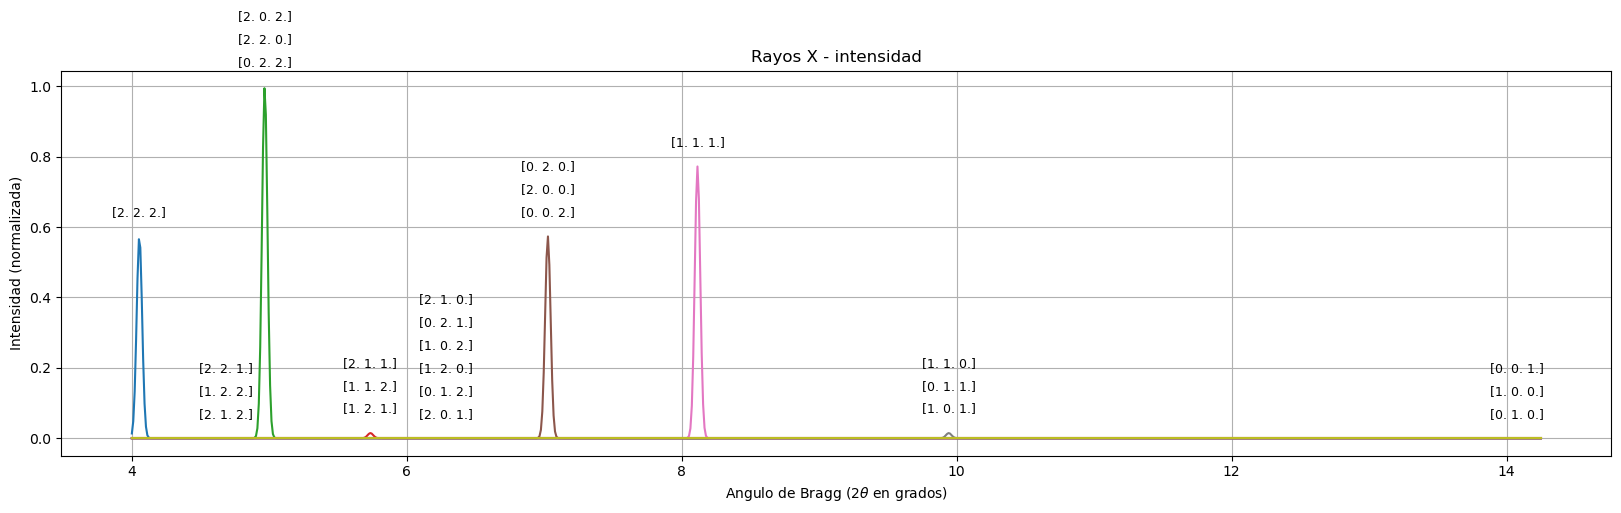

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))

##### Esto me lo dijo chatgpt, no tenia la mas remota idea de como hacerlo
# Dominio continuo para la gráfica
x = np.linspace(4, 14.25, 1000)

# Ancho de las campanas (muy pequeño)
sigma = 0.02

# Graficar cada delta como una gaussiana angosta
for xi, ai in zip(theta_times2, intensity):
    y = ai * np.exp(- (x - xi)**2 / (2*sigma**2))
    plt.plot(x, y)
##### Hasta aquí

# Añadir las etiquetas encima de cada punto
for i in range(len(theta)):
    for j in range(counts[i]):
        plt.text(theta_times2[i], intensity[i] + 0.05 + 0.065*j,  # un poquito por encima
                f"{Miller_indexes[idx[i] + j]}",    # convierte (1,1,1) a texto
                ha='center', va='bottom',
                fontsize=9)

# Etiquetas y títulos
plt.xlabel(r"Angulo de Bragg ($2\theta$ en grados)")
plt.ylabel("Intensidad (normalizada)")
plt.title("Rayos X - intensidad")
plt.grid(True)

plt.show()

In [ ]:
print("Miller indexes (h, k, l):")
print(Miller_indexes_unique)
print("\nBragg angles (degrees):")
print(theta)
print("\nIntensities (normalized):")
print(intensity)

Miller indexes (h, k, l):
[[2. 2. 2.]
 [2. 1. 2.]
 [0. 2. 2.]
 [1. 2. 1.]
 [2. 0. 1.]
 [0. 0. 2.]
 [1. 1. 1.]
 [1. 0. 1.]
 [0. 1. 0.]]

Bragg angles (degrees):
[2.02737224 2.34117077 2.48327303 2.86773626 3.14171033 3.51297965
 4.05728844 4.97122621 7.03925323]

Intensities (normalized):
[5.73921028e-01 1.50100002e-30 1.00000000e+00 1.46923783e-02
 3.39133009e-33 5.73921028e-01 7.72268136e-01 1.46923783e-02
 2.95062932e-33]


# 